imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

dataset

In [2]:
data = pd.read_csv('obesity_prediction.csv')
data.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity_level
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:

import altair as alt

# Create a scatter plot of weight vs. height, colored by obesity level
alt.Chart(data).mark_circle().encode(
    x='Weight',
    y='Height',
    color='Obesity_level'
).interactive()


alt.Chart(...)

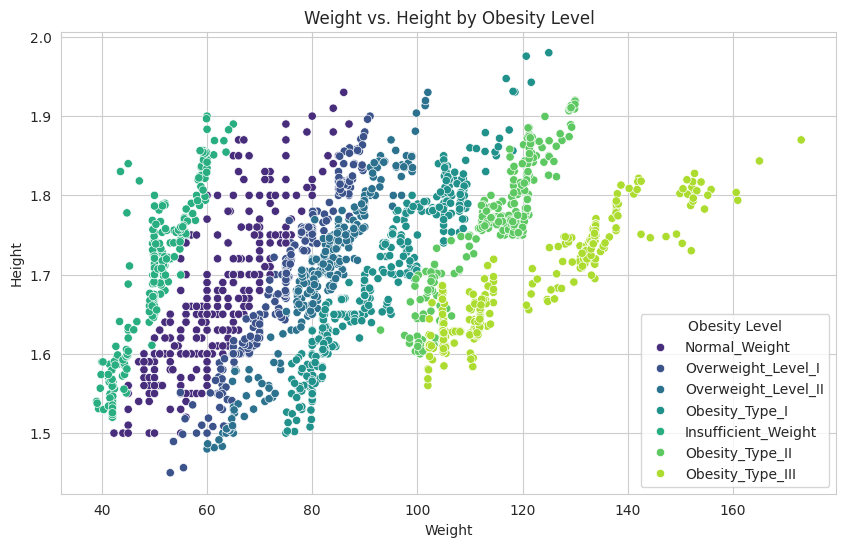

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Weight', y='Height', hue='Obesity_level', palette='viridis')
plt.title('Weight vs. Height by Obesity Level')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.legend(title='Obesity Level')
plt.show()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity_level   2111 non-null   object 
dtypes: float64(8), object(9)
memory u

missing values

In [8]:
data.isnull().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
family_history,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0


target

In [9]:
X = data.drop(columns=['Obesity_level'])
y = data['Obesity_level']

identifying categorical and numerical columns

In [10]:
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns


defining a column transfromer for preprocessing

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

im gonna create a pipeline for PCA and RandomForest

In [12]:
pca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),  # Explained variance of 95%
    ('classifier', RandomForestClassifier(random_state=42))
])


creating a pipeline for data without PCA and RandomForest

In [13]:
nopca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

spliting the data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


training without pca

In [15]:
nopca_pipeline.fit(X_train, y_train)
y_pred_original = nopca_pipeline.predict(X_test)

with pca

In [16]:
pca_pipeline.fit(X_train, y_train)
y_pred_pca = pca_pipeline.predict(X_test)

evaluation

In [17]:
print("Without PCA:")
print(classification_report(y_test, y_pred_original))
print("With PCA:")
print(classification_report(y_test, y_pred_pca))

Without PCA:
                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.93      0.94        86
      Normal_Weight       0.78      0.89      0.83        93
     Obesity_Type_I       0.97      0.93      0.95       102
    Obesity_Type_II       0.97      0.99      0.98        88
   Obesity_Type_III       1.00      0.99      0.99        98
 Overweight_Level_I       0.89      0.84      0.87        88
Overweight_Level_II       0.95      0.90      0.92        79

           accuracy                           0.93       634
          macro avg       0.93      0.92      0.93       634
       weighted avg       0.93      0.93      0.93       634

With PCA:
                     precision    recall  f1-score   support

Insufficient_Weight       0.87      0.93      0.90        86
      Normal_Weight       0.70      0.70      0.70        93
     Obesity_Type_I       0.90      0.88      0.89       102
    Obesity_Type_II       0.94      0.97      0.96        

visualization confusion matrix

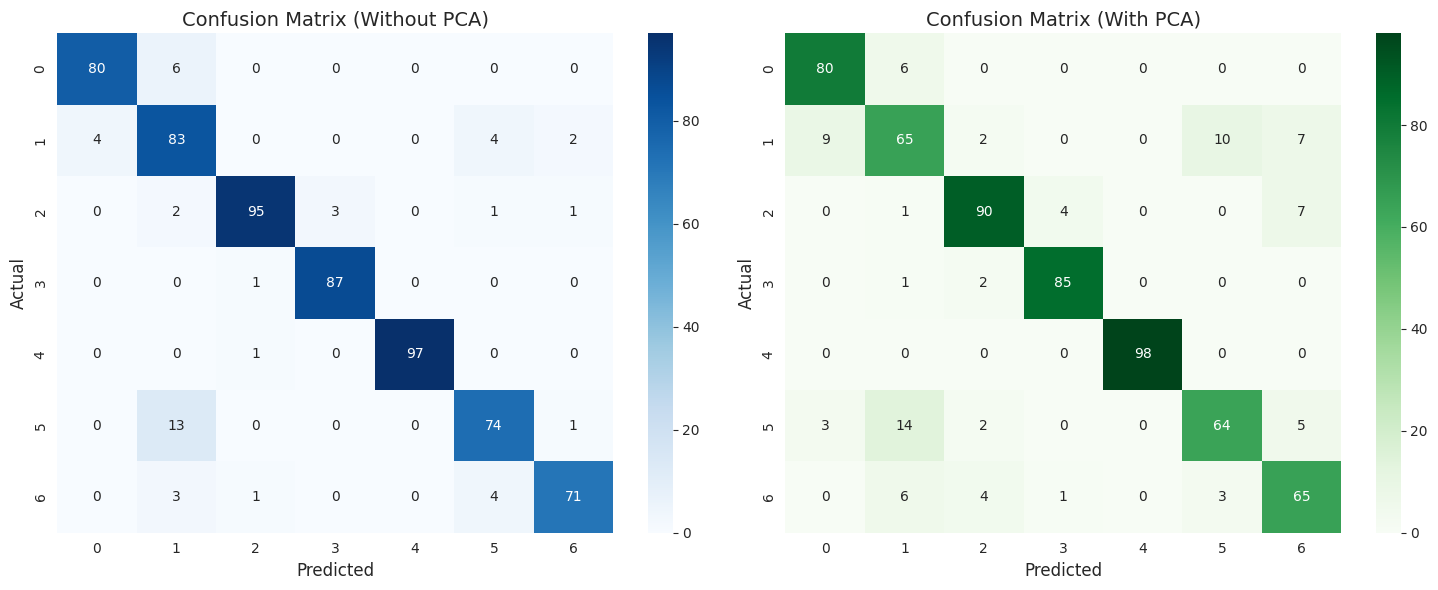

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_original), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Without PCA)', fontsize=14)
ax[0].set_xlabel('Predicted', fontsize=12)
ax[0].set_ylabel('Actual', fontsize=12)
sns.heatmap(confusion_matrix(y_test, y_pred_pca), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Confusion Matrix (With PCA)', fontsize=14)
ax[1].set_xlabel('Predicted', fontsize=12)
ax[1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

im encoding target variable to numeric values

In [19]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

im getting pca tranformed data from the pipeline

In [20]:
X_pca_reduced = pca_pipeline.named_steps['pca'].transform(preprocessor.fit_transform(X))


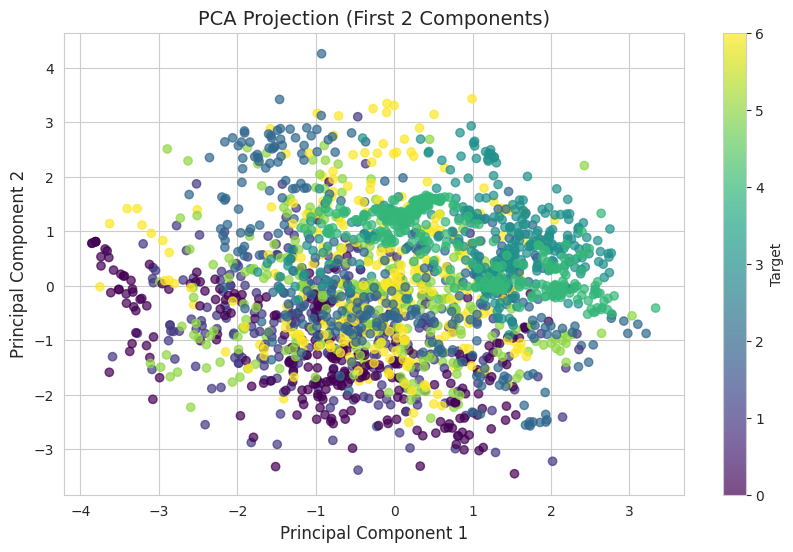

In [21]:
if X_pca_reduced.shape[1] >= 2:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y_encoded, cmap='viridis', alpha=0.7)
    plt.colorbar(label='Target')
    plt.title('PCA Projection (First 2 Components)', fontsize=14)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.grid(True)
    plt.show()

 Now i want to also visualize the manifold learning but idk if it is gonna work or not


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


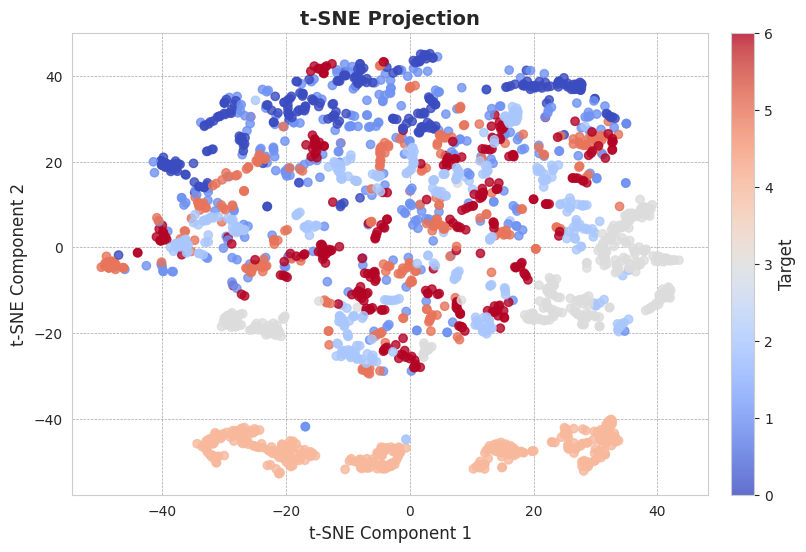

In [22]:
# im performing t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, learning_rate='auto', init='random')
X_tsne = tsne.fit_transform(preprocessor.fit_transform(X))


fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap='coolwarm', alpha=0.8)
colorbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.03)
colorbar.set_label('Target', fontsize=12)
ax.set_title('t-SNE Projection', fontsize=14, fontweight='bold')
ax.set_xlabel('t-SNE Component 1', fontsize=12)
ax.set_ylabel('t-SNE Component 2', fontsize=12)
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

summary of evaluation

In [24]:
print("Without PCA:")
print(classification_report(y_test, y_pred_original))
print("With PCA:")
print(classification_report(y_test, y_pred_pca))
print("Accuracy without PCA:", accuracy_score(y_test, y_pred_original))
print("Accuracy with PCA:", accuracy_score(y_test, y_pred_pca))

Without PCA:
                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.93      0.94        86
      Normal_Weight       0.78      0.89      0.83        93
     Obesity_Type_I       0.97      0.93      0.95       102
    Obesity_Type_II       0.97      0.99      0.98        88
   Obesity_Type_III       1.00      0.99      0.99        98
 Overweight_Level_I       0.89      0.84      0.87        88
Overweight_Level_II       0.95      0.90      0.92        79

           accuracy                           0.93       634
          macro avg       0.93      0.92      0.93       634
       weighted avg       0.93      0.93      0.93       634

With PCA:
                     precision    recall  f1-score   support

Insufficient_Weight       0.87      0.93      0.90        86
      Normal_Weight       0.70      0.70      0.70        93
     Obesity_Type_I       0.90      0.88      0.89       102
    Obesity_Type_II       0.94      0.97      0.96        